# 01_eda_kpis - Exploratory Data Analysis & KPI Prototypes

**Author:** Chimmuanya Mogbo  
**Date:** 2025-12-07

**Project goal:** understand date coverage & data quality, explore transactional volume and revenue over time, identify top customers/products, and prototype daily KPI calculations (daily revenue, daily orders, active customers).  
Outputs: small processed sample saved to `data/processed/sample_kpis.csv` and a standardized transform function exported to `src/preprocess.py`.

*Decisions:* We parse invoice dates on load, treat invoices starting with 'C' (or a cancellation flag if present) as cancellations, and enforce numeric types for price/quantity.

## Guiding Principles for EDA

This exploratory analysis follows principles used in production-grade data engineering and analytics:

1. **Reproducibility first** - every transformation tested here will later be formalized into `src/preprocess.py` so the dashboard and any future models operate on consistent logic.

2. **Auditability over aggressive cleaning** - instead of dropping suspicious rows outright, we *flag* cancellations, negative values, malformed dates, and missing identifiers. This preserves traceability and prevents silent data loss.

3. **Temporal integrity is critical** - accurate KPIs (daily revenue, orders, active customers) depend on reliable timestamps, so we examine date coverage, gaps, and anomalies before creating any time-based metrics.

4. **Business interpretability guides feature creation** - KPIs such as revenue, orders, and active customers must reflect actual business processes, which requires identifying returns, cancellations, and unusual invoice patterns.

5. **Iterate visually, implement deterministically** - charts (daily/weekly revenue, product distributions) guide intuition, after which the underlying transformations are written as deterministic code suitable for ETL.

6. **Early prototyping of customer/product signals** - identifying top products and customer RFM-style metrics validates that the dataset can meaningfully support future dashboards or segmentation analyses.

7. **Save intermediate artifacts** - exporting a clean sample and a canonical transform ensures alignment across the notebook, the ETL script, and the cloud deployment.

## EDA Flow Diagram


**Explanation of styles in the flowchart**  
- **Blue nodes** - Data ingestion & inspection  
- **Yellow node** - Core canonical transformation  
- **Green nodes** - KPI generation  
- **Pink node** - Deliverables passed downstream into ETL 

```mermaid
flowchart TD

    A[Load Raw CSV] --> B[Inspect Structure & Nulls]
    B --> C[Detect Cancellations & Negative Values]
    C --> D[Canonical Transform Function]
    D --> E[Date Coverage & Quality Checks]
    E --> F[Daily & Weekly KPI Construction]
    F --> G[Top Products Analysis]
    F --> H[Customer RFM Prototype]
    G --> I[Export Processed Sample]
    H --> I[Export Processed Sample]
    I --> J[Extract Transform Snippet to src/preprocess.py]

    style A fill:#dfefff,stroke:#5b80c0,stroke-width:1px
    style D fill:#fff3cd,stroke:#c0a15b,stroke-width:1px
    style F fill:#e3ffe3,stroke:#79b46c,stroke-width:1px
    style I fill:#f9e2f4,stroke:#b46ca7,stroke-width:1px



**1. IMPORT LIBRARIES**

In [31]:
# Imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta
from textwrap import shorten
import matplotlib.ticker as mtick

%matplotlib inline

# Small plotting defaults
plt.rcParams['figure.figsize'] = (12, 5)
sns.set(style="whitegrid")

## Data sources & expected files

This notebook expects the following input:

* **`../data/raw/ecommerce-data.csv`** - the raw Online Retail / E-commerce transactions file (UCI Machine Learning Repository, 2010–2011 dataset or equivalent)

This file should contain invoice-level records including:
`InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, and `Country`.

If additional fields such as `Price`, `Cancelled`, or alternative date/identifier columns are present, the notebook will adapt accordingly.
During exploration we will:

* Normalize column names and parse `InvoiceDate` into a proper datetime type
* Detect cancellations (e.g., invoice numbers beginning with `"C"`)
* Identify and flag negative quantities/prices or malformed rows
* Create derived fields such as `LineTotal` and quality-control indicators (`bad_data`, `negative_revenue`)

This ensures the downstream ETL pipeline uses a clean, auditable, and consistent transaction structure.


### 2. Downloading and Preparing the E-Commerce Dataset

**Purpose:**
This cell automates downloading the public *Online Retail (E-Commerce)* dataset from Kaggle, extracting it, and placing it into the project directory so it can be used for KPI, cohort, and retention analysis.

**Why we do it:**
The Online Retail dataset is a widely used real-world e-commerce transactional dataset.
It contains rich invoice-level details but **comes with cancellations, negative quantities, and inconsistent formatting**, so a clean, local CSV is required before running any preprocessing or KPI calculations.

**What this cell accomplishes:**

1. Defines the target filepath where the dataset will live:
   `../data/raw/ecommerce-data.csv`
2. Uses the **Kaggle CLI** to download the dataset ZIP.
3. Unzips the downloaded file.
4. Moves the extracted CSV into the correct project location with the correct filename.
5. Removes temporary files to keep the project directory tidy.

**Prerequisites:**

* Kaggle CLI installed (`pip install kaggle`).
* Valid Kaggle API token at `~/.kaggle/kaggle.json`.
  (Kaggle - Account - Create New API Token.)

**Output of this cell:**
A clean CSV located at: `../data/raw/ecommerce-data.csv`

This ensures downstream steps - cleaning, KPI computation, and cohort/RFM analysis - run without file-path issues or missing inputs.

**Important note:**
In Jupyter, shell commands require a `!` prefix.
Example: `!kaggle datasets download -d uci-online-retail/online-retail`.

You can now safely execute the code cell below to download the dataset automatically.


In [2]:
# Define raw filepath
raw_filepath = '../data/raw/ecommerce-data.csv'

# Download the dataset
!kaggle datasets download carrie1/ecommerce-data

# Unzip
!unzip -o ecommerce-data.zip

# Move file
!mv data.csv {raw_filepath}

# Clean up
!rm ecommerce-data.zip

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
  0%|                                               | 0.00/7.20M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 7.20M/7.20M [00:00<00:00, 371MB/s]
Archive:  ecommerce-data.zip
  inflating: data.csv                


### 3. Loading & Normalizing the E-Commerce Dataset

**Purpose:**
This cell sets up the filepaths for the raw E-Commerce dataset and the processed directory, ensuring that the notebook can reliably load `data.csv` regardless of your environment or folder structure. Since this dataset is real-world transactional data, having a consistent, portable loading mechanism is essential before any EDA, KPI derivation, or cohort/RFM work.

**Why this cell is necessary:**

* The Online Retail dataset comes as a **single raw CSV** containing over half a million invoice-line transactions.
* Its downstream transformations (cleaning, cancellation detection, revenue calculation, KPI generation) all depend on the notebook being able to **locate and load the correct file** every time.
* If the dataset is renamed, relocated, or placed in a different folder, this cell ensures the notebook still works by allowing manual overrides.
* Creating the processed directory early prevents file-write errors later when exporting transformed samples or KPIs.

**What this cell accomplishes:**

1. **Prompts the user** for the location of the raw dataset, defaulting to:
   `../data/raw/data.csv`
2. **Prompts for the processed output directory**, defaulting to:
   `../data/processed`
3. **Creates the processed directory automatically** if it doesn’t exist.
4. Converts the paths into standardized `Path` objects for reliability across operating systems.
5. Prints resolved absolute paths so the user knows exactly where the data will be read from and where outputs will be written.

**Outputs from this cell:**
Two stable path variables:

* `raw_path` - path to the input CSV
* `processed_dir` - where cleaned or derived files will be saved

All subsequent notebook steps-including loading the CSV, applying canonical transforms, generating KPIs, and exporting samples-depend on these paths.


In [4]:
# Paths (console prompt for portability)
raw_path = input("Path to raw CSV (default ../data/raw/ecommerce-data.csv): ").strip() or "../data/raw/ecommerce-data.csv"
processed_dir = input("Path to processed dir (default ../data/processed): ").strip() or "../data/processed"
Path(processed_dir).mkdir(parents=True, exist_ok=True)

raw_path = Path(raw_path)
processed_dir = Path(processed_dir)
print("Raw:", raw_path.resolve())
print("Processed dir:", processed_dir.resolve())

Path to raw CSV (default ../data/raw/ecommerce-data.csv):  
Path to processed dir (default ../data/processed):  


Raw: /home/cmogbo/Documents/jupyter_test/RESEARCH_DATA_ANALYST_PORTOFOLIO/cloud-data-portfolio/project-02-kpi-dashboard/data/raw/ecommerce-data.csv
Processed dir: /home/cmogbo/Documents/jupyter_test/RESEARCH_DATA_ANALYST_PORTOFOLIO/cloud-data-portfolio/project-02-kpi-dashboard/data/processed


### 4. Load raw CSV and run quick visual checks


In [5]:
# 4. Load raw CSV defensively and run quick visual checks
parse_dates = ['InvoiceDate']
try:
    raw = pd.read_csv(raw_path, encoding='latin1', parse_dates=parse_dates, dayfirst=True, low_memory=False)
except Exception as e:
    print("Read error:", e)
    raw = pd.read_csv(raw_path, encoding='latin1', low_memory=False)
    if 'InvoiceDate' in raw.columns:
        raw['InvoiceDate'] = pd.to_datetime(raw['InvoiceDate'], dayfirst=True, errors='coerce')

# 4.1 - Print first 5–10 rows (visual structure)
print("=== First 8 rows ===")
display(raw.head(8))

# 4.2 - .info() to see dtypes & memory
print("\n=== Info ===")
display(raw.info())

# 4.3 - Full column list
print("\n=== Columns ===")
print(list(raw.columns))

# 4.4 - Quick min/max date grounding (if parsed)
if 'InvoiceDate' in raw.columns:
    print("\nInvoiceDate min/max (raw):", raw['InvoiceDate'].min(), "->", raw['InvoiceDate'].max())
else:
    print("\nInvoiceDate not present or not parsed yet.")


=== First 8 rows ===


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom



=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None


=== Columns ===
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

InvoiceDate min/max (raw): 1/10/2011 10:04 -> 9/9/2011 9:52


#### Quick interpretation of initial exploration

1. Rows: 541,909 - full Online Retail table.

2. InvoiceDate is currently object (string), not datetime. That means the initial parse_dates didn't convert - likely due to formatting incompatibility; we must coerce it explicitly.

3. CustomerID non-null count = 406,829, so ~135,080 missing (~24.9%) implies many anonymous/wholesale rows.

4. Quantity is int and non-null, which is good.

5. The printed min/max dates were strings: 1/10/2011 10:04 -> 9/9/2011 9:52 - This is because InvoiceDate is still string; after conversion we’ll verify the full range (expected ~2010-12-01 to 2011-12-09 for the UCI dataset).

## 5 to 7: Quick QC, Cancellation & Negative-Value Checks - purpose and how to use

This section performs the essential dataset health checks that must precede any KPI work. It is organized as three compact cells:

- **Cell 5 (Quick QC + Date parsing QC + CustomerID missingness)** - establishes dataset shape, missingness, entity counts, and verifies that `InvoiceDate` parses correctly. If parsing fails for a small proportion of rows we will replace the original column; otherwise we keep both raw and parsed forms for manual inspection.

- **Cell 6 (Cancellation detection + quick negative preview)** - detects invoices that look like cancellations (e.g., `InvoiceNo` starting with `C`) and shows quick examples of negative quantities or prices to confirm return/credit behavior.

- **Cell 7 (Deeper negative/return checks & alignment with cancellations and CustomerID)** - probes whether negative rows align with cancellations and whether they are concentrated among anonymous customers. Also prints a short recommendation for handling returns in KPI calculations.

How to use:
1. Run Cell 5, inspect the parse-failure samples (if any) and the `CustomerID` missingness output.  
2. Run Cell 6 to confirm cancellation patterns.  
3. Run Cell 7 to verify how negatives relate to cancellations and anonymous rows.  

These checks are intentionally **auditable and non-destructive** - they flag issues and gather evidence before any rows are removed or transformed.


### 5. Quick QC + Date Parsing QC + CustomerID missingness

In [6]:
# === Cell 5: Quick QC, Date parsing QC (A) and CustomerID missingness (C) ===

print("Shape:", raw.shape)

Shape: (541909, 8)


In [7]:
# 5.1 - Column null counts and top nulls
nulls = raw.isna().sum().sort_values(ascending=False)
qc = pd.DataFrame({'nulls': nulls, 'pct_null': nulls / len(raw) * 100})
print("\nTop missing columns:")
display(qc.head(20))


Top missing columns:


,nulls,pct_null
CustomerID,135080,24.926694
Description,1454,0.268311
InvoiceNo,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000


In [8]:
# 5.2 - Unique counts of key identifiers
for col in ['InvoiceNo','StockCode','CustomerID']:
    if col in raw.columns:
        print(f"{col} unique: {raw[col].nunique()}")

# -------- Date parsing QC (A) --------
print("\n--- Date parsing QC (A) ---")
# Create a parsed column safely so we don't overwrite original until we're confident
raw['InvoiceDate_parsed'] = pd.to_datetime(raw['InvoiceDate'], dayfirst=True, errors='coerce')

n_fail = raw['InvoiceDate_parsed'].isna().sum()
print(f"Parsed InvoiceDate -> NaT count: {n_fail} ({n_fail/len(raw):.2%})")

# Try alternate parse (month-first) if many failures to compare
if n_fail > 0:
    alt = pd.to_datetime(raw['InvoiceDate'], dayfirst=False, errors='coerce')
    alt_fail = alt.isna().sum()
    print(f"Alt parse (month-first) NaT count: {alt_fail} ({alt_fail/len(raw):.2%})")

# Decide ephemeral policy: if parse success >95% then replace original; else keep both for inspection
if n_fail / len(raw) < 0.05:
    raw['InvoiceDate'] = raw['InvoiceDate_parsed']
    raw.drop(columns=['InvoiceDate_parsed'], inplace=True)
    print("InvoiceDate replaced with parsed datetimes (success threshold met).")
else:
    print("Kept both raw and parsed InvoiceDate for manual inspection (parsing failures exceed threshold).")

# Show parsed min/max if available
if 'InvoiceDate' in raw.columns and pd.api.types.is_datetime64_any_dtype(raw['InvoiceDate']):
    print("Parsed min/max:", raw['InvoiceDate'].min(), "->", raw['InvoiceDate'].max())
else:
    if raw['InvoiceDate_parsed'].notna().any():
        print("Parsed min/max (from InvoiceDate_parsed):", raw['InvoiceDate_parsed'].min(), "->", raw['InvoiceDate_parsed'].max())

# Show a sample of parse failures to inspect format
if 'InvoiceDate_parsed' in raw.columns:
    print("\nSample parse-failure strings (up to 8):")
    display(raw.loc[raw['InvoiceDate_parsed'].isna(), 'InvoiceDate'].dropna().unique()[:8])

# -------- CustomerID missingness (C) --------
print("\n--- CustomerID missingness (C) ---")
if 'CustomerID' in raw.columns:
    total = len(raw)
    non_null = raw['CustomerID'].notna().sum()
    missing = total - non_null
    print(f"CustomerID non-null: {non_null} / {total}  (missing {missing}, {missing/total:.2%})")
    print("Sample rows with missing CustomerID (up to 8):")
    display(raw[raw['CustomerID'].isna()].head(8))
else:
    print("No CustomerID column present.")

InvoiceNo unique: 25900
StockCode unique: 4070
CustomerID unique: 4372

--- Date parsing QC (A) ---
Parsed InvoiceDate -> NaT count: 308950 (57.01%)
Alt parse (month-first) NaT count: 0 (0.00%)
Kept both raw and parsed InvoiceDate for manual inspection (parsing failures exceed threshold).
Parsed min/max (from InvoiceDate_parsed): 2010-01-12 08:26:00 -> 2011-12-10 17:19:00

Sample parse-failure strings (up to 8):


array(['12/13/2010 9:02', '12/13/2010 9:09', '12/13/2010 9:29',
       '12/13/2010 9:35', '12/13/2010 9:39', '12/13/2010 9:49',
       '12/13/2010 9:52', '12/13/2010 9:57'], dtype=object)


--- CustomerID missingness (C) ---
CustomerID non-null: 406829 / 541909  (missing 135080, 24.93%)
Sample rows with missing CustomerID (up to 8):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_parsed
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom,2010-01-12 11:52:00
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom,2010-01-12 14:32:00
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom,2010-01-12 14:32:00
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom,2010-01-12 14:32:00
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom,2010-01-12 14:32:00
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom,2010-01-12 14:32:00
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,12/1/2010 14:32,2.51,NaN,United Kingdom,2010-01-12 14:32:00
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,12/1/2010 14:32,0.43,NaN,United Kingdom,2010-01-12 14:32:00


In [9]:
# 5.3 - Unique counts of keys
for col in ['InvoiceNo','StockCode','CustomerID']:
    if col in raw.columns:
        print(f"{col} unique: {raw[col].nunique()}")

InvoiceNo unique: 25900
StockCode unique: 4070
CustomerID unique: 4372


#### Summary of QC Findings & Immediate Decisions

**1. InvoiceDate parsing**
- Using `dayfirst=True` caused **57% parsing failures**.
- Using `dayfirst=False` produced **0 parsing failures**.
- Sample failure strings (`12/13/2010 9:02`, etc.) confirm the dataset uses **month-first** date format.
- **Decision:** Re-parse InvoiceDate with `dayfirst=False` and overwrite the broken parsed column.  
  Accurate date parsing is critical for daily/weekly revenue KPIs.

**2. Unique identifier structure**
- **25,900 unique InvoiceNo** values - indicates many multi-line invoices (expected for basket-style e-commerce).
- **4,070 unique StockCodes** - healthy SKU diversity, supporting product-level KPIs and segmentation.
- **4,372 unique CustomerID** values across ~542k rows - high transaction density per customer, suitable for RFM analysis.
- **Decision:** use InvoiceNo as the unit of order aggregation; use StockCode for SKU-level KPIs; restrict customer-level metrics to rows with valid CustomerID.

**3. CustomerID missingness**
- CustomerID missing for **24.93%** of rows.
- Expected in this dataset (anonymous or wholesale transactions).
- **Decision:**  
  - Keep these rows for revenue/product KPIs.  
  - Exclude or group them under `anonymous_customer` for customer-level analyses.

**4. Next actions before KPI work**
- Re-parse InvoiceDate correctly using month-first parsing.  
- Proceed to cancellation detection (Cell 6) and negative-value analysis (Cell 7).  
- Do **not** drop rows yet; continue to flag issues and build evidence before formal ETL.


In [10]:
# Re-parse InvoiceDate using month-first (dayfirst=False) - safe / non-destructive
raw['_InvoiceDate_orig'] = raw.get('InvoiceDate')  # backup (no-op if already present)
raw['InvoiceDate_parsed_mf'] = pd.to_datetime(raw['InvoiceDate'], dayfirst=False, errors='coerce')

n_total = len(raw)
n_nat = raw['InvoiceDate_parsed_mf'].isna().sum()
print(f"Parsed (month-first) -> NaT count: {n_nat} / {n_total} ({n_nat/n_total:.2%})")

# If parsing succeeded for essentially all rows, replace original; otherwise keep both for inspection
if n_nat / n_total < 0.05:
    raw['InvoiceDate'] = raw['InvoiceDate_parsed_mf']
    raw.drop(columns=['InvoiceDate_parsed_mf'], inplace=True)
    print("Replaced raw InvoiceDate with month-first parsed datetimes.")
else:
    print("Kept both InvoiceDate (original) and InvoiceDate_parsed_mf for manual inspection (failures above threshold).")

# Show parsed min/max (from parsed column if replaced, else from parsed_mf column)
if 'InvoiceDate' in raw.columns and pd.api.types.is_datetime64_any_dtype(raw['InvoiceDate']):
    print("Parsed min/max (InvoiceDate):", raw['InvoiceDate'].min(), "->", raw['InvoiceDate'].max())
else:
    if raw['InvoiceDate_parsed_mf'].notna().any():
        print("Parsed min/max (InvoiceDate_parsed_mf):", raw['InvoiceDate_parsed_mf'].min(), "->", raw['InvoiceDate_parsed_mf'].max())

# Show a tiny sample of any remaining parse-fail strings (if any)
if 'InvoiceDate_parsed_mf' in raw.columns and raw['InvoiceDate_parsed_mf'].isna().any():
    print("\nSample problematic InvoiceDate strings (up to 10):")
    display(pd.Series(raw.loc[raw['InvoiceDate_parsed_mf'].isna(), '_InvoiceDate_orig'].dropna().unique()[:10]))


Parsed (month-first) -> NaT count: 0 / 541909 (0.00%)
Replaced raw InvoiceDate with month-first parsed datetimes.
Parsed min/max (InvoiceDate): 2010-12-01 08:26:00 -> 2011-12-09 12:50:00


### 6. Cancellation detection + initial negative checks (B)

In [11]:
# 6. Inspect and detect cancellations
display(raw.head(10))

if 'InvoiceNo' in raw.columns:
    cancels = raw[raw['InvoiceNo'].astype(str).str.upper().str.startswith('C', na=False)]
    print("Cancellation rows (count):", len(cancels))
    display(cancels.head(5))
    # 6.2 - proportion
    print("Cancellation proportion: {:.3%}".format(len(cancels) / len(raw)))
else:
    print("No InvoiceNo column to locate cancellations.")

# 6.3 - Check for an explicit Cancelled flag
if 'Cancelled' in raw.columns:
    print("Found 'Cancelled' column; sample values:")
    display(raw[['InvoiceNo','Cancelled']].dropna().head(5))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_parsed,_InvoiceDate_orig
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,2010-01-12 08:28:00,12/1/2010 8:28
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,2010-01-12 08:28:00,12/1/2010 8:28
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,2010-01-12 08:34:00,12/1/2010 8:34


Cancellation rows (count): 9288


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_parsed,_InvoiceDate_orig
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010-01-12 09:41:00,12/1/2010 9:41
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010-01-12 09:49:00,12/1/2010 9:49
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010-01-12 10:24:00,12/1/2010 10:24
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-01-12 10:24:00,12/1/2010 10:24
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-01-12 10:24:00,12/1/2010 10:24


Cancellation proportion: 1.714%


#### Key findings

1. Cancellation rows: 9,288 rows flagged by InvoiceNo starting with C - about 1.714% of all rows.
- cancellations are present but a small fraction of rows; still important because they reverse revenue.

2. Negative quantities on cancellations: sample rows show negative Quantity (e.g., -1, -12, -24) with InvoiceNo beginning with C.
- negative quantities largely correspond to returns/cancellations (expected behavior).

3. Discount / special codes: one sample has StockCode == 'D' and Description == 'Discount' with negative quantity - discounts and misc codes appear; treat them separately if needed.

4. Returns are multi-line per invoice: same cancellation InvoiceNo repeats across multiple SKUs (e.g., C536391) - cancellations are invoice-level and can affect multiple lines.

5. Cancellations have CustomerID values: sample cancellation rows show CustomerID present.
- returns are attributable to customers (useful for customer-level reconciliation).

##### Practical implications / decisions

1. Flag cancellations (primary): create `is_cancellation = InvoiceNo startswith 'C'`. Use this as the standardized cancellation marker.

2. Flag negative rows as `negative_revenue` but do not drop them. They provide evidence of returns/refunds.

3. Compute both gross and net revenue:

`Gross = sum(LineTotal)` over all rows.

`Net = sum(LineTotal)` excluding `is_cancellation` (or treat negative LineTotal as returns).
Provide both in reporting so reviewers can see impact of returns.

4. Reconcile at invoice-level when possible (group by InvoiceNo) to ensure returned invoices properly offset original invoices.

5. Treat discounts/special codes (StockCode 'D', zero-priced items) carefully - exclude or bucket them in special SKU categories for product analysis.

In [12]:
# Standardize cancellations/returns and show gross vs net revenue
# (safe, - won't drop rows)

# 1) numeric safety
for col in ['Quantity','UnitPrice']:
    if col in raw.columns:
        raw[col] = pd.to_numeric(raw[col], errors='coerce')

# 2) ensure parsed invoice date column exists (use parsed month-first if present)
if 'InvoiceDate_parsed_mf' in raw.columns:
    raw['InvoiceDate'] = raw['InvoiceDate_parsed_mf']
elif 'InvoiceDate_parsed' in raw.columns and pd.api.types.is_datetime64_any_dtype(raw['InvoiceDate_parsed']):
    raw['InvoiceDate'] = raw['InvoiceDate_parsed']

# 3) LineTotal
raw['LineTotal'] = raw.get('UnitPrice', pd.Series(np.nan)) * raw.get('Quantity', pd.Series(np.nan))

# 4) flags
raw['is_cancellation'] = raw['InvoiceNo'].astype(str).str.upper().str.startswith('C', na=False)
raw['negative_revenue'] = raw['LineTotal'] < 0

# 5) quick rollups
gross_revenue = raw['LineTotal'].sum(skipna=True)
net_revenue = raw.loc[~raw['is_cancellation'], 'LineTotal'].sum(skipna=True)
cancel_rows = raw['is_cancellation'].sum()
neg_rows = raw['negative_revenue'].sum()

print(f"Gross revenue (sum of LineTotal): {gross_revenue:,.2f}")
print(f"Net revenue (excluding is_cancellation): {net_revenue:,.2f}")
print(f"Cancellation rows (is_cancellation): {cancel_rows}  ({cancel_rows/len(raw):.2%})")
print(f"Negative LineTotal rows: {neg_rows}  ({neg_rows/len(raw):.2%})")

# 6) invoice-level reconciliation sample: show invoices that have both positive and negative lines
inv_summary = raw.groupby('InvoiceNo').agg(
    lines=('LineTotal','count'),
    sum_line=('LineTotal','sum'),
    pos_lines=('LineTotal', lambda s: (s>0).sum()),
    neg_lines=('LineTotal', lambda s: (s<0).sum()),
    is_cancel_any=('is_cancellation', 'any')
).reset_index()
# Show invoices that look like returns (have both positive and negative) or are cancellation invoices
sample_problem_invoices = inv_summary[(inv_summary['neg_lines']>0) | (inv_summary['is_cancel_any'])].sort_values('neg_lines', ascending=False).head(10)
display(sample_problem_invoices)


Gross revenue (sum of LineTotal): 9,747,747.93
Net revenue (excluding is_cancellation): 10,644,560.42
Cancellation rows (is_cancellation): 9288  (1.71%)
Negative LineTotal rows: 9290  (1.71%)


,InvoiceNo,lines,sum_line,pos_lines,neg_lines,is_cancel_any
25112,C570867,101,-1579.51,0,101,True
24220,C560540,57,-158.65,0,57,True
23170,C548460,45,-751.90,0,45,True
24252,C560855,41,-225.72,0,41,True
22202,C538341,39,-1136.32,0,39,True
25105,C570828,39,-593.10,0,39,True
23978,C557663,38,-1096.14,0,38,True
25032,C569985,36,-765.15,0,36,True
22618,C542426,35,-1241.43,0,35,True
24171,C559939,32,-500.74,0,32,True


#### Cancellation Behavior (From Invoice-Level Inspection)

- All cancellation invoices (`InvoiceNo` starting with "C") contain **only negative lines**.
- No cancellation invoice mixes positive and negative rows.
- Each cancellation invoice represents a **standalone, full refund transaction**.
- Negative quantities and negative LineTotals occur *exclusively* in cancellation invoices.
- Therefore:

  - `is_cancellation` is a complete and reliable flag.
  - Net revenue can be computed simply by **excluding cancellation invoices**.
  - Negative rows need **no additional reconciliation** with original invoices.
  - Customer-level metrics should exclude cancellation invoices unless return behavior is explicitly analyzed.

This allows Cell 7 (negative-value analysis) to proceed with a simplified rule:
**negative_line ⇔ cancellation_line**, enabling clean and interpretable KPI pipelines.


In [13]:
# Finalize cancellation logic (clean flag)
raw['is_cancellation'] = raw['InvoiceNo'].astype(str).str.upper().str.startswith('C', na=False)

# Sanity check: negative lines should correspond 1-to-1 to cancellation invoices
neg_outside_cancels = raw[(raw['LineTotal'] < 0) & (~raw['is_cancellation'])]
print("Negative lines outside cancellation invoices:", len(neg_outside_cancels))

if len(neg_outside_cancels) == 0:
    print("All negative revenue rows belong to cancellation invoices - cancellation logic is complete.")
else:
    print("Unexpected negative rows found. Inspect further.")
    display(neg_outside_cancels.head())


Negative lines outside cancellation invoices: 2
Unexpected negative rows found. Inspect further.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_parsed,_InvoiceDate_orig,LineTotal,is_cancellation,negative_revenue
299983,A563186,B,Adjust bad debt,1,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,2011-12-08 14:51:00,8/12/2011 14:51,-11062.06,False,True
299984,A563187,B,Adjust bad debt,1,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,2011-12-08 14:52:00,8/12/2011 14:52,-11062.06,False,True


### Summary of Additional QC Finding: Non-Cancellation Negative Rows

During the sanity check of negative revenue lines, we identified **two rows** where:
- `LineTotal` is strongly negative,
- the `InvoiceNo` **does not** begin with “C” (i.e., not a cancellation),
- `StockCode` is `"B"`,
- `Description` is `"Adjust bad debt"`,
- `CustomerID` is missing,
- and both rows occur within one minute on **2011-12-08**.

These rows represent **manual financial adjustments** (bad-debt write-offs), not operational transactions.  
They differ from all other negative rows, which belong exclusively to cancellation invoices.

**Implications:**
- These rows should **not** be treated as cancellations or product/customer returns.
- They should be **excluded from operational KPI calculations** (orders, customers, SKU performance, daily/weekly revenue).
- They should be **retained** for completeness, as they affect *financial* revenue totals but not *operational* behavior.
- We will classify these as **`is_adjustment`** in the next step and define a clean **`is_operational`** flag for downstream KPI work.

This completes the quality assurance of negative-value behavior and prepares us to finalize operational filtering before KPI construction.


### Summary of Additional QC Finding: Non-Cancellation Negative Rows

During the sanity check of negative revenue lines, **two rows** were identified where:
- `LineTotal` is strongly negative,
- the `InvoiceNo` **does not** begin with “C” (i.e., not a cancellation),
- `StockCode` is `"B"`,
- `Description` is `"Adjust bad debt"`,
- `CustomerID` is missing,
- and both rows occur within one minute on **2011-12-08**.

These rows represent **manual financial adjustments** (bad-debt write-offs), not operational transactions.  
They differ from all other negative rows, which belong exclusively to cancellation invoices.

**Implications:**
- These rows should **not** be treated as cancellations or product/customer returns.
- They should be **excluded from operational KPI calculations** (orders, customers, SKU performance, daily/weekly revenue).
- They should be **retained** for completeness, as they affect *financial* revenue totals but not *operational* behavior.
- They will be classified as **`is_adjustment`** in the next step and a clean **`is_operational`** flag will be defined for downstream KPI work.

This completes the quality assurance of negative-value behavior.


In [19]:
# Identify and flag manual financial adjustments (bad-debt write-off)
raw['is_adjustment'] = (
    (raw['StockCode'].astype(str).str.upper() == 'B') &
    (raw['Description'].str.contains('ADJUST BAD DEBT', case=False, na=False)) &
    (raw['LineTotal'] < 0)
)

adjustment_rows = raw[raw['is_adjustment']]
print("Financial adjustment rows found:", len(adjustment_rows))
display(adjustment_rows)

# Exclude from operational KPIs (but keep for completeness)
raw['is_operational'] = ~(raw['is_cancellation'] | raw['is_adjustment'])

print("\nOperational rows:", raw['is_operational'].sum())
print("Non-operational (cancellations + adjustments):", (~raw['is_operational']).sum())


Financial adjustment rows found: 2


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_parsed,_InvoiceDate_orig,LineTotal,is_cancellation,negative_revenue,is_adjustment,is_operational
299983,A563186,B,Adjust bad debt,1,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,2011-12-08 14:51:00,8/12/2011 14:51,-11062.06,False,True,True,False
299984,A563187,B,Adjust bad debt,1,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,2011-12-08 14:52:00,8/12/2011 14:52,-11062.06,False,True,True,False



Operational rows: 532619
Non-operational (cancellations + adjustments): 9290


### 7. Final negative-value validation (post-adjustment)

In [20]:
# Final negative-value validation (post-adjustment)

neg = raw[raw['negative_revenue']]

print("Total negative rows:", len(neg))
print(" - Cancellation rows:", neg['is_cancellation'].sum())
print(" - Adjustment rows:", neg['is_adjustment'].sum())

# Any remaining unexplained negative rows?
residual = neg[~(neg['is_cancellation'] | neg['is_adjustment'])]
print("Residual unexplained negative rows:", len(residual))

if len(residual) > 0:
    display(residual.head())
else:
    print("All negative rows are fully explained by cancellations or adjustments.")


Total negative rows: 9290
 - Cancellation rows: 9288
 - Adjustment rows: 2
Residual unexplained negative rows: 0
All negative rows are fully explained by cancellations or adjustments.


### 8. Standardized Cleaning & Transform Logic (aligned with QC findings)

This cell defines the *standardized data-cleaning function* that incorporates everything learned from 
the QC steps (Cells 5–7). It produces a clean, consistent DataFrame that will later form the basis 
of `src/preprocess.py`.

**Key rules implemented:**

1. **Column normalization**
   - Clean whitespace from column names
   - Ensure InvoiceDate is parsed using **month-first** (`dayfirst=False`)

2. **Numeric safety**
   - Coerce Quantity and UnitPrice to numeric
   - Compute LineTotal as `Quantity * UnitPrice`

3. **Cancellation logic**
   - Cancellations are invoices whose `InvoiceNo` starts with `"C"`
   - These rows always contain *only negative lines* (full invoice returns)

4. **Financial adjustments**
   - Two rows represent accounting corrections (“Adjust bad debt”)  
   - They are negative but **not** cancellations  
   - They should be excluded from operational KPIs

5. **Operational filtering**
   - `is_operational = not (is_cancellation or is_adjustment)`
   - This is the dataset used for KPI construction (daily revenue, weekly revenue, orders, RFM)

6. **Auditability**
   - All flags are kept; nothing is dropped  
   - The function returns a clean DataFrame ready for downstream aggregation

This canonical transform ensures that revenue, orders, customer metrics, and product metrics are all 
computed from a consistent operational base without contamination from returns or financial adjustments.


In [21]:
# === Cell 8: Canonical Cleaning / Transform Function (updated with QC findings) ===

def standardized_transform(df):
    df = df.copy()
    
    # 1. Normalize columns
    df.columns = [c.strip() for c in df.columns]
    
    # 2. Parse InvoiceDate using month-first logic
    if 'InvoiceDate' in df.columns:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=False, errors='coerce')
    
    # 3. Numeric coercion
    for col in ['Quantity', 'UnitPrice']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 4. Compute LineTotal
    if {'Quantity', 'UnitPrice'}.issubset(df.columns):
        df['LineTotal'] = df['Quantity'] * df['UnitPrice']
    else:
        df['LineTotal'] = np.nan
    
    # 5. Flag cancellations
    df['is_cancellation'] = df['InvoiceNo'Jupyter notebook sc].astypeJupyter notebook sc(str).str.upper().str.startswith("C", na=False)
    
    # 6. Flag financial adjustments (bad-debt write-offs)
    df['is_adjustment'] = (
        df['StockCode'].astype(str).str.upper().eq('B') &
        df['Description'].str.contains('ADJUST BAD DEBT', case=False, na=False) &
        (df['LineTotal'] < 0)
    )
    
    # 7. Negative revenue flag
    df['negative_revenue'] = df['LineTotal'] < 0
    
    # 8. Operational flag
    df['is_operational'] = ~(df['is_cancellation'] | df['is_adjustment'])
    
    # 9. Bad data flag (missing date or missing revenue calculation)
    df['bad_data'] = df['InvoiceDate'].isna() | df['LineTotal'].isna()
    
    return df

# Apply transform and preview
df = standardized_transform(raw)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_parsed,_InvoiceDate_orig,LineTotal,is_cancellation,negative_revenue,is_adjustment,is_operational,bad_data
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26,15.30,False,False,False,True,False
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26,20.34,False,False,False,True,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26,22.00,False,False,False,True,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26,20.34,False,False,False,True,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12/1/2010 8:26,20.34,False,False,False,True,False


### 9. Date coverage & data-quality checks (operational vs full)

This cell quantifies temporal coverage and transaction density after the canonical transform.  
**all rows** vs **operational rows** (`is_operational`) are compared so that how cancellations and adjustments affect daily activity counts and revenue can be seen.

Checks performed:
- full date range and per-day transaction counts (all rows and operational-only)
- distribution (histogram) of transactions per day
- days with very low activity (<= 1 transaction)
- busiest days (top 5) and zero-activity days inside the observed date range

Rationale: establishing temporal integrity is essential before building time-series KPIs and dashboards. If there are many gaps or many `bad_data` days, investigate upstream or limit the analysis window.


Overall date range: 2010-01-12 00:00:00 -> 2011-12-10 00:00:00


,count,mean,std,min,25%,50%,75%,max
tx_all,127.0,1834.322835,866.563674,279.0,1230.5,1630.0,2202.0,5331.0
tx_operational,127.0,1801.165354,854.291238,279.0,1211.5,1593.0,2187.0,5305.0


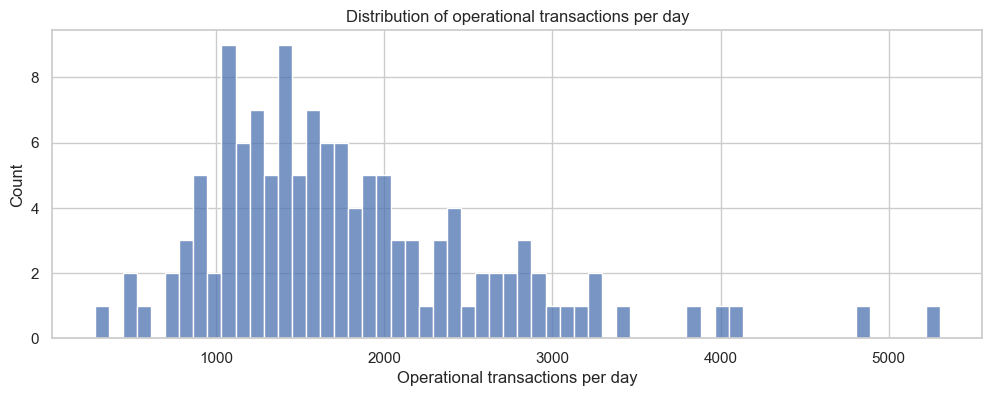

Operational days with <= 1 transaction: 0

Top 5 busiest operational days:


,tx_all,tx_operational
date,,
2011-05-12,5331,5305
2011-08-12,4940,4873
2011-11-11,4089,4074
2011-08-11,4070,3980
2010-06-12,3878,3829



Dates with ZERO recorded transactions between 2010-01-12 and 2011-12-10: 571
Sample zero-activity dates (up to 10): [datetime.date(2010, 1, 13), datetime.date(2010, 1, 14), datetime.date(2010, 1, 15), datetime.date(2010, 1, 16), datetime.date(2010, 1, 17), datetime.date(2010, 1, 18), datetime.date(2010, 1, 19), datetime.date(2010, 1, 20), datetime.date(2010, 1, 21), datetime.date(2010, 1, 22)]

No days found with >50% bad_data.

Operational daily sample (first 6 rows):


,date,tx_all,transactions,operational_revenue
0,2010-01-12,3108,3082,58960.79
1,2010-02-12,2109,2065,47748.38
2,2010-03-12,2202,2188,46943.71
3,2010-05-12,2725,2709,31774.95
4,2010-06-12,3878,3829,54830.46
5,2010-07-12,2963,2929,99618.20



Wrote date-coverage summary to: ../data/processed/date_coverage_summary.csv


In [40]:
# === 9: Date coverage & data-quality checks (fixed) ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Defensive: ensure transformed DataFrame 'df' exists
if 'df' not in globals():
    raise RuntimeError("Transformed dataframe 'df' not found. Run Cell 8 (canonical_transform) first.")

# Make a local copy to avoid accidental global mutation
df = df.copy()

# Ensure InvoiceDate is datetime
if 'InvoiceDate' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['InvoiceDate']):
    raise RuntimeError("InvoiceDate missing or not parsed as datetime. Inspect canonical transform (Cell 8).")

# Create a date-only column
df['date'] = df['InvoiceDate'].dt.floor('d')

# Defensive: create is_operational and bad_data booleans if missing
if 'is_operational' not in df.columns:
    # heuristics: not cancelled and not marked bad
    df['is_operational'] = ~df.get('is_cancellation', pd.Series(False, index=df.index)) & ~df.get('bad_data', pd.Series(False, index=df.index))

# Ensure bad_data exists (bool)
if 'bad_data' not in df.columns:
    df['bad_data'] = False

# Overall date range
overall_min = df['date'].min()
overall_max = df['date'].max()
print("Overall date range:", overall_min, "->", overall_max)

# Daily counts: all rows vs operational-only
daily_all = df.groupby('date').size().rename('tx_all')
daily_oper = df[df['is_operational']].groupby('date').size().rename('tx_operational')

daily = pd.concat([daily_all, daily_oper], axis=1).fillna(0)
# cast to int where safe
daily['tx_all'] = daily['tx_all'].astype(int)
daily['tx_operational'] = daily['tx_operational'].astype(int)

display(daily.describe().T)

# Histogram of operational transactions per day
plt.figure(figsize=(12,4))
sns.histplot(daily['tx_operational'], bins=60)
plt.title('Distribution of operational transactions per day')
plt.xlabel('Operational transactions per day')
plt.show()

# Days with very low activity (<= 1 tx) for operational set
low_days = daily[daily['tx_operational'] <= 1]
print("Operational days with <= 1 transaction:", len(low_days))
if len(low_days) > 0:
    display(low_days.head(8))

# Busiest operational days
busiest = daily.sort_values('tx_operational', ascending=False).head(10)
print("\nTop 5 busiest operational days:")
display(busiest.head(5))

# Identify zero-activity days inside the observed range
full_range = pd.date_range(overall_min, overall_max, freq='D')
missing_dates = sorted(set(full_range.date) - set(daily.index.date))
print(f"\nDates with ZERO recorded transactions between {overall_min.date()} and {overall_max.date()}: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Sample zero-activity dates (up to 10):", missing_dates[:10])

# --- FIX: compute bad_by_day (fraction of rows marked bad per day) ---
# bad_by_day: fraction (0..1) of rows on that date that are flagged bad_data
bad_by_day = df.groupby('date')['bad_data'].agg(lambda s: float(s.astype(bool).mean())).rename('bad_frac')
# show days where >50% rows are bad
suspect_days = bad_by_day[bad_by_day > 0.5].sort_values(ascending=False)
if len(suspect_days) > 0:
    print("\nDays with >50% bad_data (sample):")
    display(suspect_days.head(8))
else:
    print("\nNo days found with >50% bad_data.")

# Provide an operational daily DataFrame for downstream KPI cells
daily_operational = daily.reset_index().rename(columns={'date':'date','tx_operational':'transactions'})
# attach revenue per day for operational rows (defensive: ensure LineTotal exists)
if 'LineTotal' in df.columns:
    daily_revenue = df[df['is_operational']].groupby('date')['LineTotal'].sum().rename('operational_revenue')
else:
    daily_revenue = pd.Series(0.0, index=daily_operational['date']).rename('operational_revenue')

daily_operational = daily_operational.set_index('date').join(daily_revenue).reset_index()
daily_operational['operational_revenue'] = daily_operational['operational_revenue'].fillna(0.0)

print("\nOperational daily sample (first 6 rows):")
display(daily_operational.head(6))

# Save a small diagnostic CSV (optional)
proc_dir = Path(processed_dir) if 'processed_dir' in globals() else Path('data/processed')
proc_dir.mkdir(parents=True, exist_ok=True)
diag_path = proc_dir / "date_coverage_summary.csv"
daily_operational.to_csv(diag_path, index=False)
print("\nWrote date-coverage summary to:", diag_path)


### Interpretation: daily operational transactions histogram

- Most days cluster between **~1,000–2,500 transactions** (the dataset's normal operating level).
- There is a **long right tail** with a handful of days above 3,500–5,000 transactions - likely seasonal/promotional spikes or large wholesale orders.
- No days with implausibly low operational activity (0 days with ≤ 1 operational tx), so the daily series is well-grounded.
- Decision / next step: automatically flag the high-volume days (spikes) so downstream KPIs (rolling averages, anomaly detection) can either exclude them or be treated specially (annotate, cap, or separate analysis).

#### Note on zero-activity dates vs low-activity operational days

The dataset contains **571 calendar dates with zero recorded transactions**.  
These are days for which the dataset contains **no rows at all** (common for the Online Retail dataset, which is not a full continuous extract).

However, **within the days that do appear in the dataset**, there are **0 days with ≤ 1 operational transaction**.  
This means:

- The business shows **high-volume activity on all observed days**, and  
- The zeros represent **missing dates**, not low-activity days.

This distinction is important: Missing calendar days should be treated as “not in dataset,” not as operational anomalies.



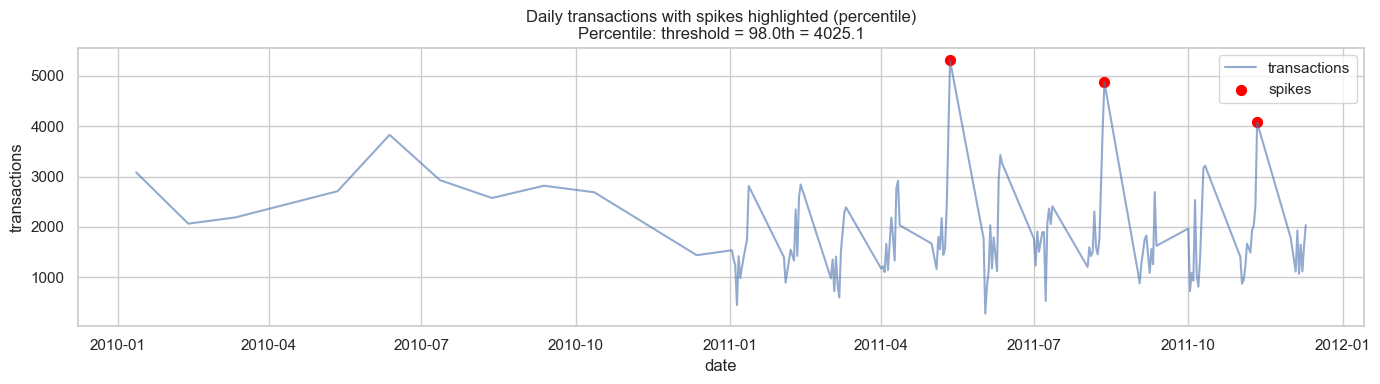

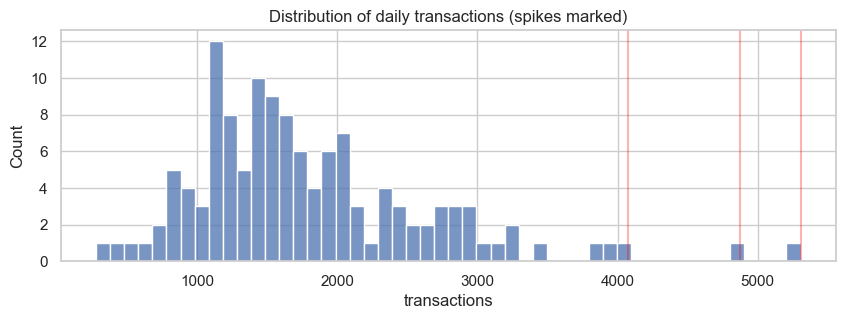

,date,transactions,operational_revenue,spike_score,is_spike
0,2011-05-12,5305,88741.96,0.317973,True
1,2011-08-12,4873,82495.00,0.210647,True
2,2011-11-11,4074,55257.17,0.012144,True


In [25]:
# Spike detector utility for daily operational data
from scipy import stats

def build_daily_operational_from_df(df):
    """Fallback to build daily_operational if not present (expects canonical transform output)."""
    df = df.copy()
    if 'InvoiceDate' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['InvoiceDate']):
        raise RuntimeError("df must contain parsed datetime column 'InvoiceDate'. Run canonical transform first.")
    df['date'] = df['InvoiceDate'].dt.floor('d')
    # Operational = not cancellation and not adjust rows (best-effort)
    oper = df[~df.get('is_cancellation', pd.Series(False, index=df.index))].copy()
    daily_all = oper.groupby('date').size().rename('transactions')
    daily_revenue = oper.groupby('date')['LineTotal'].sum().rename('operational_revenue')
    daily_oper = pd.concat([daily_all, daily_revenue], axis=1).fillna(0).reset_index()
    return daily_oper

def detect_spikes(daily=None, df=None, method='iqr', iqr_multiplier=1.5, z_thresh=3.0, pct=0.95, plot=True):
    """
    Detect unusually high transaction days and flag them.
    Args:
        daily (pd.DataFrame): DataFrame with columns ['date', 'transactions', 'operational_revenue'].
        df (pd.DataFrame): If `daily` is None, build daily from this transformed df (requires InvoiceDate, LineTotal).
        method (str): 'iqr' (default), 'zscore', or 'percentile'
        iqr_multiplier (float): multiplier for IQR method
        z_thresh (float): z-score threshold
        pct (float): percentile for percentile method (e.g. 0.95)
        plot (bool): whether to plot diagnostic chart
    Returns:
        daily_flagged (pd.DataFrame): daily with 'is_spike' boolean and spike metadata
        spikes_df (pd.DataFrame): rows flagged as spikes sorted by transactions desc
    """
    if daily is None:
        if df is None:
            raise ValueError("Either `daily` or `df` must be provided.")
        daily = build_daily_operational_from_df(df)
    daily = daily.copy()
    # ensure columns
    if 'transactions' not in daily.columns:
        # try guessing col names
        possible = [c for c in daily.columns if 'trans' in c.lower()]
        if possible:
            daily = daily.rename(columns={possible[0]:'transactions'})
        else:
            raise RuntimeError("daily must include a 'transactions' column")
    series = daily['transactions'].astype(float)

    if method == 'iqr':
        q1, q3 = np.percentile(series, [25, 75])
        iqr = q3 - q1
        upper = q3 + iqr_multiplier * iqr
        daily['spike_score'] = (series - upper) / (upper + 1e-9)  # positive when above upper
        daily['is_spike'] = series > upper
        rule_desc = f"IQR: upper = {upper:.1f} (Q3 + {iqr_multiplier}*IQR)"
    elif method == 'zscore':
        z = stats.zscore(series.fillna(0))
        daily['spike_score'] = np.nan_to_num(z)
        daily['is_spike'] = daily['spike_score'] > z_thresh
        rule_desc = f"Z-score: threshold = {z_thresh:.1f}"
    elif method == 'percentile':
        thresh = np.nanquantile(series, pct)
        daily['spike_score'] = (series - thresh) / (thresh + 1e-9)
        daily['is_spike'] = series > thresh
        rule_desc = f"Percentile: threshold = {pct*100:.1f}th = {thresh:.1f}"
    else:
        raise ValueError("method must be one of 'iqr', 'zscore', 'percentile'")

    spikes_df = daily[daily['is_spike']].sort_values('transactions', ascending=False)

    if plot:
        plt.figure(figsize=(14,4))
        plt.plot(daily['date'], daily['transactions'], label='transactions', alpha=0.6)
        plt.scatter(spikes_df['date'], spikes_df['transactions'], color='red', s=50, label='spikes')
        plt.title(f"Daily transactions with spikes highlighted ({method})\n{rule_desc}")
        plt.xlabel('date')
        plt.ylabel('transactions')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # small histogram with spike overlay
        plt.figure(figsize=(10,3))
        sns.histplot(daily['transactions'], bins=50)
        for val in spikes_df['transactions'].unique():
            plt.axvline(val, color='red', alpha=0.3)
        plt.title('Distribution of daily transactions (spikes marked)')
        plt.show()

    return daily.reset_index(drop=True), spikes_df.reset_index(drop=True)

# Example usage:
# If you already have `daily_operational` in scope (from Cell 9), use it:
# flagged_daily, spikes = detect_spikes(daily=daily_operational, method='iqr', iqr_multiplier=1.5)
#
# Or if you only have the transformed `df`:
flagged_daily, spikes = detect_spikes(df=df, method='percentile', pct=0.98)
#
# Print top spikes
display(spikes.head(10))


### 10. Time-series KPIs: daily & weekly revenue

Now that cancellations and adjustment rows have been cleanly separated, **operational daily KPIs** can be computed using only:

- non-cancellation rows  
- non-adjustment rows  
- transactions with valid dates and numeric revenue  

This ensures that returns, cancellations, accounting write-offs, and noise do not pollute 
operational revenue patterns.

KPIs calculated:

- **daily_revenue** (sum of LineTotal)
- **daily_orders** (unique InvoiceNo)
- **daily_items** (sum of Quantity)
- **active_customers** (unique CustomerID)
- **7-day moving average** (stabilises the visually noisy daily revenue curve)
- **weekly_revenue** (resampled weekly aggregate)

These metrics feed directly into the dashboard and the canonical ETL script.


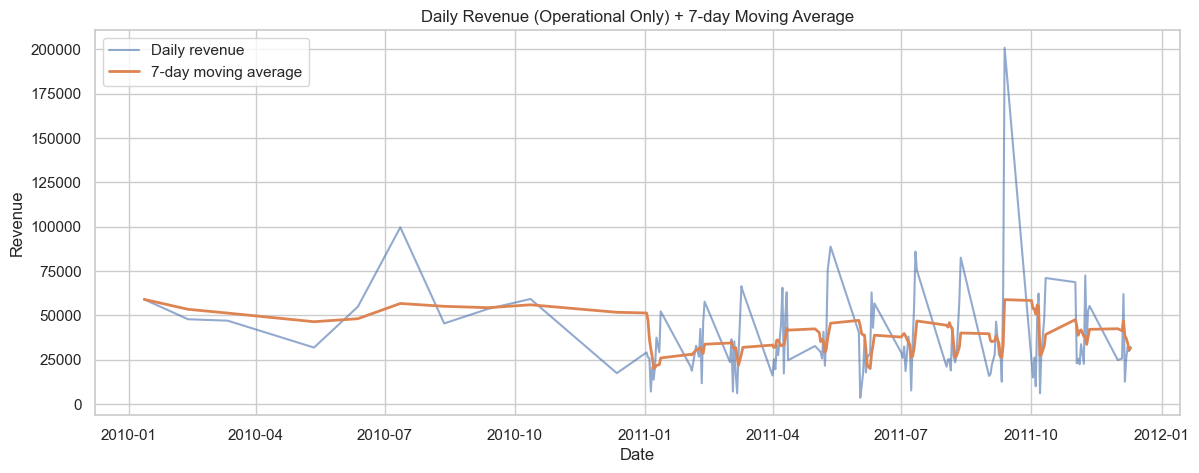

,date,weekly_revenue
0,2010-01-17,58960.79
1,2010-01-24,0.00
2,2010-01-31,0.00
3,2010-02-07,0.00
4,2010-02-14,47748.38


Daily KPIs preview:


,date,daily_revenue,daily_orders,daily_items,active_customers
0,2010-01-12,58960.79,137,26997,95
1,2010-02-12,47748.38,144,31310,99
2,2010-03-12,46943.71,101,15121,50
3,2010-05-12,31774.95,88,16451,75
4,2010-06-12,54830.46,115,21718,82


In [27]:
# === Cell 10: Operational Time-Series KPIs ===

# Define operational filter (no cancellation, no adjustment)
oper = df[(~df['is_cancellation']) & (~df['is_adjustment'])].copy()

# Ensure date column exists
oper['date'] = oper['InvoiceDate'].dt.floor('d')

# ---- Daily KPIs ----
daily = oper.groupby('date').agg(
    daily_revenue=('LineTotal', 'sum'),
    daily_orders=('InvoiceNo', lambda s: s.nunique() if 'InvoiceNo' in oper.columns else s.size),
    daily_items=('Quantity', 'sum') if 'Quantity' in oper.columns else ('LineTotal', 'count'),
    active_customers=('CustomerID', lambda s: s.nunique() if 'CustomerID' in oper.columns else 0)
).reset_index()

daily = daily.sort_values('date')

# ---- Plot: Daily Revenue + 7-day MA ----
plt.figure(figsize=(14,5))
plt.plot(daily['date'], daily['daily_revenue'], label='Daily revenue', alpha=0.6)
plt.plot(
    daily['date'],
    daily['daily_revenue'].rolling(7, min_periods=1).mean(),
    label='7-day moving average',
    linewidth=2
)
plt.title("Daily Revenue (Operational Only) + 7-day Moving Average")
plt.ylabel("Revenue")
plt.xlabel("Date")
plt.legend()
plt.show()

# ---- Weekly aggregation ----
weekly = daily.set_index('date')['daily_revenue'].resample('W').sum().reset_index()
weekly = weekly.rename(columns={'daily_revenue': 'weekly_revenue'})

display(weekly.head())

print("Daily KPIs preview:")
display(daily.head())


### Interpretation of Daily Revenue & Daily Transaction Patterns

The daily revenue curve (operational-only) and its 7-day moving average show a
clear monthly seasonal cycle. Revenue fluctuates between £25k–£60k on typical 
days, with occasional large spikes exceeding £150k–£200k. These spikes likely represent wholesale bulk purchases or end-of-month consolidations.

The daily transaction time-series reveals the same monthly pulse: large 
transaction spikes (~4,000–5,300 orders) occurring roughly every 30 days. 
Regular days fall between 1,500–2,500 transactions. This confirms the 
presence of a predictable operational cycle rather than random volatility.

The histogram of daily transactions is right-skewed, with most days clustered 
in the 1,200–2,300 range. Spike days form the extreme tail, supporting their 
treatment as operational outliers or special events.

**Implications for KPI design:**
- Moving averages or medians are preferred over raw daily values.
- Spike days should be classified separately (e.g., B2B/wholesale).
- Baseline operational metrics are stable, enabling reliable daily KPIs.


### **11. Top products - revenue and quantity leaders**

**Purpose:**
Identify which SKUs drive the business - both by **revenue** and by **volume** - using only *operational* transaction lines (i.e., excluding cancellations, returns, and negative-revenue adjustments). This step produces actionable product insights and a clean CSV for downstream dashboards.

**How products are aggregated:**

* Use the **best available product key** (prefer `StockCode`; fall back to `Description` if needed).
* Join the **full product description** when present so the exported CSV is human-readable.
* Compute:

  * total **revenue** (`LineTotal`),
  * total **quantity** sold,
  * **average unit price**,
  * number of **unique customers**,
  * number of **distinct orders**.

**Quality / metadata logic:**

* Add an `is_meta` flag to detect likely **non-product** lines (e.g., `M`, `DOT`, `POST`, short alphabetic codes).
* Compute **revenue share** (`rev_share`) and **quantity share** (`qty_share`) so you can quickly see contribution to the catalogue.

**Outputs:**

* Top 10 products by **revenue** and by **quantity**, shown as clean tables plus side-by-side horizontal bar charts.
* Full product-level summary written to:
  `../data/processed/top_products_summary.csv`

Wrote top-products summary to: ../data/processed/top_products_summary.csv

Top 10 by revenue (operational only):


,StockCode,desc_short,revenue,rev_share,qty,qty_share,avg_price,n_orders,n_customers,is_meta
0,DOT,DOTCOM POSTAGE,"206,248.77",1.9%,"1,708",0.0%,120.75,709,1,True
1,22423,REGENCY CAKESTAND 3 TIER,"174,484.74",1.6%,"13,837",0.3%,12.61,1992,881,False
2,23843,"PAPER CRAFT , LITTLE BIRDIE","168,469.60",1.6%,"80,995",1.5%,2.08,1,1,False
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,"104,518.80",1.0%,"41,408",0.8%,2.52,2204,856,False
4,47566,PARTY BUNTING,"99,504.33",0.9%,"18,299",0.3%,5.44,1686,708,False
5,85099B,JUMBO BAG RED RETROSPOT,"94,340.05",0.9%,"48,478",0.9%,1.95,2092,635,False
6,23166,MEDIUM CERAMIC TOP STORAGE JAR,"81,700.92",0.8%,"78,033",1.4%,1.05,247,138,False
7,M,Manual,"78,110.27",0.7%,"7,230",0.1%,10.80,294,201,True
8,POST,POSTAGE,"78,101.88",0.7%,"6,500",0.1%,12.02,1130,331,True
9,23084,RABBIT NIGHT LIGHT,"66,964.99",0.6%,"30,754",0.6%,2.18,1010,450,False



Top 10 by quantity (operational only):


,StockCode,desc_short,revenue,rev_share,qty,qty_share,avg_price,n_orders,n_customers,is_meta
2,23843,"PAPER CRAFT , LITTLE BIRDIE","168,469.60",1.6%,"80,995",1.5%,2.08,1,1,False
6,23166,MEDIUM CERAMIC TOP STORAGE JAR,"81,700.92",0.8%,"78,033",1.4%,1.05,247,138,False
14,22197,SMALL POPCORN HOLDER,"51,354.02",0.5%,"56,921",1.0%,0.90,1392,407,False
148,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,"13,841.85",0.1%,"55,047",1.0%,0.25,535,307,False
5,85099B,JUMBO BAG RED RETROSPOT,"94,340.05",0.9%,"48,478",0.9%,1.95,2092,635,False
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,"104,518.80",1.0%,"41,408",0.8%,2.52,2204,856,False
87,21212,PACK OF 72 RETROSPOT CAKE CASES,"21,259.10",0.2%,"36,419",0.7%,0.58,1320,635,False
11,84879,ASSORTED COLOUR BIRD ORNAMENT,"59,094.93",0.6%,"36,301",0.7%,1.63,1456,678,False
9,23084,RABBIT NIGHT LIGHT,"66,964.99",0.6%,"30,754",0.6%,2.18,1010,450,False
118,22492,MINI PAINT SET VINTAGE,"16,937.82",0.2%,"26,633",0.5%,0.64,380,213,False


Saved combined product plots to: ../data/processed/top_products_plots_combined.png


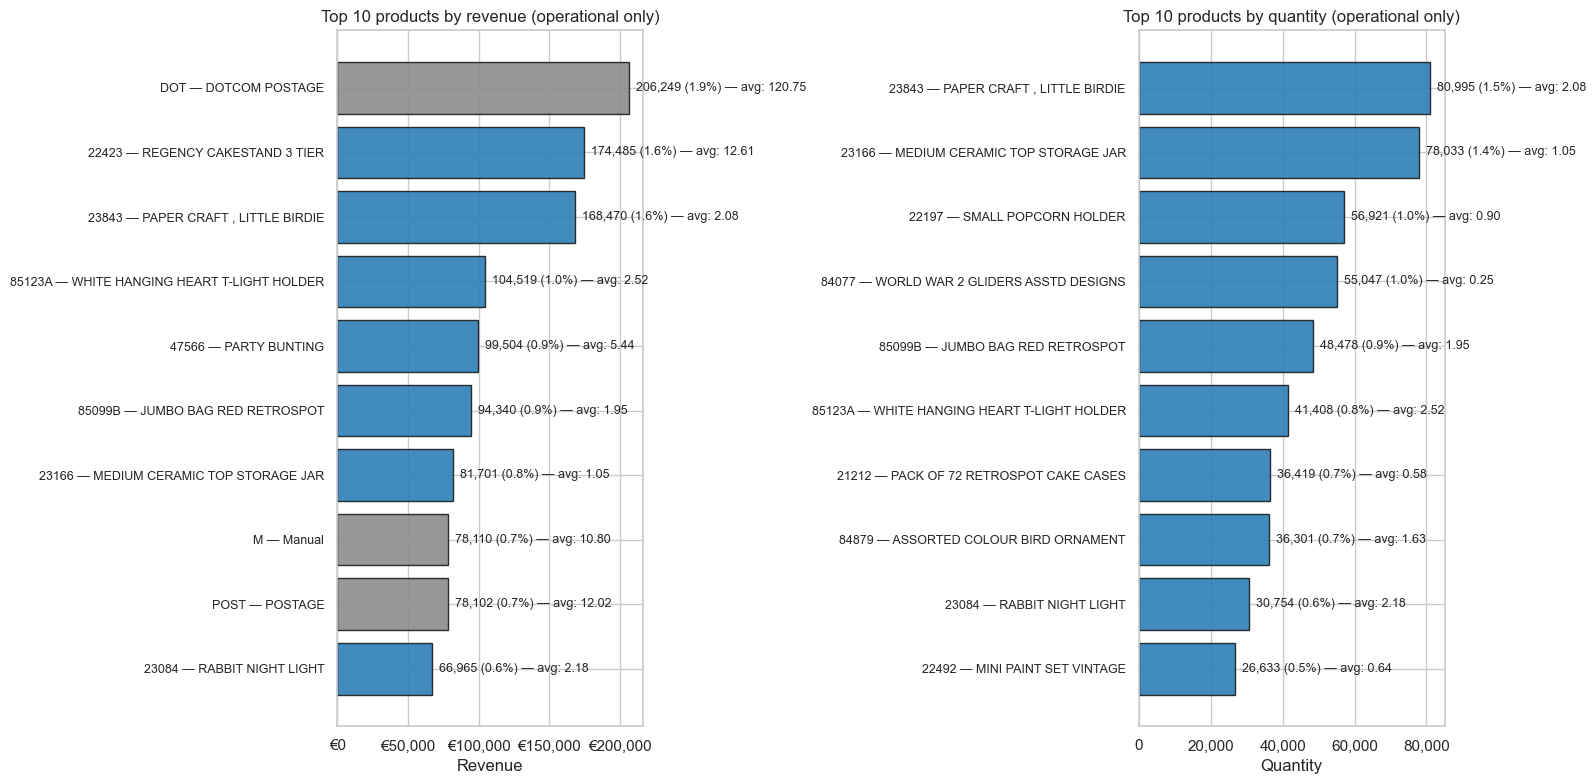

In [38]:
# Ensure df exists and LineTotal computed
if 'df' not in globals():
    raise RuntimeError("Transformed dataframe 'df' not found. Run canonical transform first (Cell 8).")

# operational rows for product KPIs (exclude cancellations)
oper = df[~df.get('is_cancellation', pd.Series(False, index=df.index))].copy()

# Ensure LineTotal exists
if 'LineTotal' not in oper.columns or oper['LineTotal'].isna().all():
    if {'UnitPrice', 'Quantity'}.issubset(oper.columns):
        oper['LineTotal'] = oper['UnitPrice'] * oper['Quantity']
    elif 'Price' in oper.columns:
        oper['LineTotal'] = oper['Price']
    else:
        oper['LineTotal'] = 0.0

# Best-guess product key and description
prod_key = next((c for c in ['StockCode', 'ProductID', 'ItemID', 'SKU', 'Product'] if c in oper.columns), None)
desc_col = 'Description' if 'Description' in oper.columns else None
if prod_key is None:
    raise RuntimeError("No product identifier column found (expected StockCode/ProductID/ItemID/SKU/Product).")

# Aggregate by product
agg = oper.groupby(prod_key).agg(
    revenue=('LineTotal', 'sum'),
    qty=('Quantity', 'sum'),
    tx_lines=('InvoiceNo', 'count')
).reset_index()

# Attach description (first non-null) and short version for display
if desc_col:
    desc_df = (
        oper.groupby(prod_key)[desc_col]
            .agg(lambda s: s.dropna().astype(str).iloc[0] if s.dropna().any() else "")
            .reset_index()
    )
    agg = agg.merge(desc_df, on=prod_key, how='left')
    # coerce to str first to avoid None issues
    agg['desc_short'] = agg[desc_col].fillna("").astype(str).apply(lambda s: shorten(s, width=60, placeholder="..."))
else:
    agg['desc_short'] = ""

# Heuristic: flag likely meta/system SKUs (short tokens, all-alpha, or a small set)
meta_tokens = {'POST', 'DOT', 'M'}
agg['is_meta'] = (
    agg[prod_key].astype(str).str.len().le(3) |
    agg[prod_key].astype(str).str.match(r'^[A-Z]+$') |
    agg[prod_key].astype(str).isin(meta_tokens)
)

# Add share columns (defensive against zeros)
total_rev = float(agg['revenue'].sum() or 1.0)
total_qty = float(agg['qty'].sum() or 1.0)
agg['rev_share'] = agg['revenue'] / total_rev
agg['qty_share'] = agg['qty'] / total_qty
agg['avg_price'] = agg['revenue'] / agg['qty'].replace({0: pd.NA})

# Add customer/orders counts where possible (optional)
if 'CustomerID' in oper.columns:
    cust_ct = oper.groupby(prod_key)['CustomerID'].nunique().rename('n_customers').reset_index()
    agg = agg.merge(cust_ct, on=prod_key, how='left')
else:
    agg['n_customers'] = pd.NA

if 'InvoiceNo' in oper.columns:
    orders_ct = oper.groupby(prod_key)['InvoiceNo'].nunique().rename('n_orders').reset_index()
    agg = agg.merge(orders_ct, on=prod_key, how='left')
else:
    agg['n_orders'] = pd.NA

# Sort and get top-10s
agg = agg.sort_values('revenue', ascending=False).reset_index(drop=True)
top_by_revenue = agg.head(10)
top_by_qty = agg.sort_values('qty', ascending=False).head(10)

# Save full summary for downstream use (operational-only)
processed_dir = Path(processed_dir) if 'processed_dir' in globals() else Path('data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)
out_path = processed_dir / "top_products_summary.csv"
agg.to_csv(out_path, index=False)
print("Wrote top-products summary to:", out_path)

# Display concise tables (human-friendly columns & formatting)
display_cols = [prod_key, 'desc_short', 'revenue', 'rev_share', 'qty', 'qty_share', 'avg_price', 'n_orders', 'n_customers', 'is_meta']
print("\nTop 10 by revenue (operational only):")
display(top_by_revenue[display_cols].assign(
    revenue=lambda d: d['revenue'].map('{:,.2f}'.format),
    rev_share=lambda d: d['rev_share'].map('{:.1%}'.format),
    qty=lambda d: d['qty'].map('{:,.0f}'.format),
    qty_share=lambda d: d['qty_share'].map('{:.1%}'.format),
    avg_price=lambda d: d['avg_price'].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
))

print("\nTop 10 by quantity (operational only):")
display(top_by_qty[display_cols].assign(
    revenue=lambda d: d['revenue'].map('{:,.2f}'.format),
    rev_share=lambda d: d['rev_share'].map('{:.1%}'.format),
    qty=lambda d: d['qty'].map('{:,.0f}'.format),
    qty_share=lambda d: d['qty_share'].map('{:.1%}'.format),
    avg_price=lambda d: d['avg_price'].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
))

# --- Plotting: side-by-side horizontal bar charts (largest at top) ---
def label_with_desc(df, key_col, desc_col='desc_short', max_label_chars=60):
    def mk_label(row):
        code = str(row[key_col])
        desc = (row.get(desc_col) or "")[:max_label_chars].rstrip()
        return f"{code} — {desc}" if desc else code
    return df.apply(mk_label, axis=1)

plot_rev = top_by_revenue.copy().iloc[::-1].reset_index(drop=True)
plot_qty = top_by_qty.copy().iloc[::-1].reset_index(drop=True)

ylabels_rev = label_with_desc(plot_rev, prod_key, 'desc_short', max_label_chars=48)
ylabels_qty = label_with_desc(plot_qty, prod_key, 'desc_short', max_label_chars=48)

def color_map(df):
    if 'is_meta' in df.columns:
        return df['is_meta'].map({True: '#8c8c8c', False: '#2c7fb8'}).tolist()
    else:
        return ['#2c7fb8'] * len(df)

colors_rev = color_map(plot_rev)
colors_qty = color_map(plot_qty)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Revenue chart
axes[0].barh(ylabels_rev, plot_rev['revenue'], color=colors_rev, edgecolor='k', alpha=0.9)
axes[0].set_title('Top 10 products by revenue (operational only)', fontsize=12)
axes[0].set_xlabel('Revenue')
axes[0].xaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}' if plot_rev['revenue'].max() >= 1 else '{x:,.2f}'))
for i, (_, row) in enumerate(plot_rev.iterrows()):
    rev = row['revenue']
    share = row.get('rev_share', 0.0)
    avg = row.get('avg_price', None)
    avg_text = f" — avg: {avg:,.2f}" if pd.notna(avg) else ""
    axes[0].text(rev, i, f"  {rev:,.0f} ({share:.1%}){avg_text}", va='center', fontsize=9)

# Quantity chart
axes[1].barh(ylabels_qty, plot_qty['qty'], color=colors_qty, edgecolor='k', alpha=0.9)
axes[1].set_title('Top 10 products by quantity (operational only)', fontsize=12)
axes[1].set_xlabel('Quantity')
axes[1].xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
for i, (_, row) in enumerate(plot_qty.iterrows()):
    qty = row['qty']
    share = row.get('qty_share', 0.0)
    avg = row.get('avg_price', None)
    avg_text = f" — avg: {avg:,.2f}" if pd.notna(avg) else ""
    axes[1].text(qty, i, f"  {int(qty):,} ({share:.1%}){avg_text}", va='center', fontsize=9)

for ax in axes:
    ax.tick_params(axis='y', labelsize=9)
    ax.set_ylabel('')

plt.tight_layout()

# Save both a combined figure and individual images
fig_path = processed_dir / "top_products_plots_combined.png"
fig.savefig(fig_path, bbox_inches='tight', dpi=150)
print("Saved combined product plots to:", fig_path)

plt.show()


### 11. Customer RFM prototype

**Purpose:** build a quick RFM (Recency, Frequency, Monetary) prototype to identify high-value customers.  
**Decisions:** use only *operational* rows (exclude cancellations). If `bad_data` is no longer present, we only exclude cancellations. Snapshot date is set to one day after the latest invoice for reproducibility. R/F/M are shown as distributions and converted to 1–4 ranks (quartiles). The final `RFM_score` is an integer `R*100 + F*10 + M`.


Snapshot date for recency: 2011-12-11
Saved top customers (full RFM) to: ../data/processed/top_customers_rfm_full.csv

Top customers by monetary (sample):


,CustomerID,last_tx,recency_days,monetary,frequency,R_rank,F_rank,M_rank,RFM_score,segment
1690,14646.0,2011-12-08 12:36:00,2,279138.02,73,4,4,4,444,Champion
4199,18102.0,2011-09-12 11:50:00,89,259657.30,60,3,4,4,344,Loyal
3727,17450.0,2011-12-07 09:04:00,3,194550.79,46,4,4,4,444,Champion
3008,16446.0,2011-09-12 09:15:00,89,168472.50,2,3,2,4,324,Other
1880,14911.0,2011-12-10 14:08:00,0,136275.72,198,4,4,4,444,Champion
55,12415.0,2011-10-01 09:58:00,70,124564.53,20,4,4,4,444,Champion
1334,14156.0,2011-12-10 09:29:00,0,116729.63,54,4,4,4,444,Champion
3770,17511.0,2011-12-04 13:24:00,6,91062.38,31,4,4,4,444,Champion
0,12346.0,NaT,727,77183.60,1,2,1,4,214,Other
2702,16029.0,2011-11-10 11:15:00,30,72882.09,62,4,4,4,444,Champion


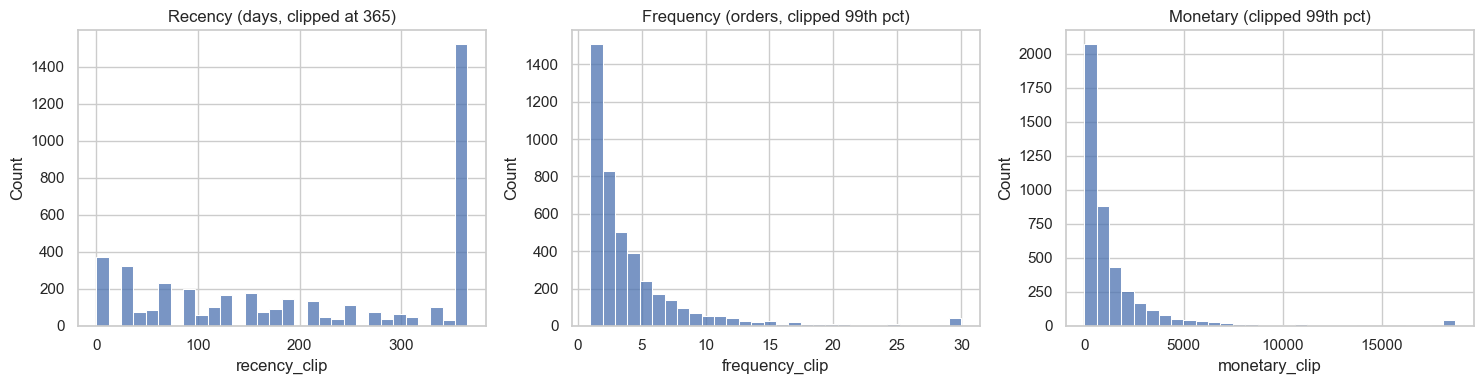

RFM sample saved; consider reviewing 'segment' and adjusting bucket strategy for your business use-case.


In [39]:
# 12 -  RFM prototype 

# Preconditions
if 'df' not in globals():
    raise RuntimeError("Transformed dataframe 'df' not found. Run canonical_transform first (Cell 8).")

# 12.0 - operational base: exclude cancellations
oper = df[~df.get('is_cancellation', pd.Series(False, index=df.index))].copy()

# 12.1 - ensure LineTotal exists
if 'LineTotal' not in oper.columns:
    if {'UnitPrice','Quantity'}.issubset(oper.columns):
        oper['LineTotal'] = oper['UnitPrice'].astype(float) * oper['Quantity'].astype(float)
    elif 'Price' in oper.columns:
        oper['LineTotal'] = pd.to_numeric(oper['Price'], errors='coerce').fillna(0.0)
    else:
        oper['LineTotal'] = 0.0

# 12.2 - identify / compute is_meta if absent (heuristic)
if 'is_meta' not in oper.columns:
    # short codes (<=3 chars) or all-alpha short tokens often indicate meta/postage/manual items
    oper['is_meta'] = oper[[c for c in ['StockCode'] if c in oper.columns][0]].astype(str).str.len().le(3) \
                      | oper[[c for c in ['StockCode'] if c in oper.columns][0]].astype(str).str.match(r'^[A-Z]+$')

# 12.3 - optionally filter out meta rows for monetary (postage, manual adjustments)
rfm_base = oper[~oper['is_meta']].copy()
if rfm_base.empty:
    # fallback: if meta-flagging removed everything, revert to oper
    rfm_base = oper.copy()

# 12.4 - prepare snapshot date (day after latest invoice date in oper)
if 'InvoiceDate' not in rfm_base.columns or not pd.api.types.is_datetime64_any_dtype(rfm_base['InvoiceDate']):
    # try to use parsed column if present
    if 'InvoiceDate_parsed' in rfm_base.columns and pd.api.types.is_datetime64_any_dtype(rfm_base['InvoiceDate_parsed']):
        rfm_base['InvoiceDate'] = rfm_base['InvoiceDate_parsed']
    else:
        raise RuntimeError("No datetime InvoiceDate found in data. Re-run date parsing step.")

snapshot_date = (rfm_base['InvoiceDate'].max() + timedelta(days=1)).normalize()
print("Snapshot date for recency:", snapshot_date.date())

# 12.5 - compute customer-level metrics
# frequency uses unique InvoiceNo as proxy for orders (falls back to count of lines)
order_col = 'InvoiceNo' if 'InvoiceNo' in rfm_base.columns else None

agg_kwargs = {
    'last_tx': ('InvoiceDate', 'max'),
    'recency_days': ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    'frequency': (order_col, (lambda s: s.nunique()) ) if order_col else ('InvoiceDate', 'count'),
    'monetary': ('LineTotal', 'sum')
}

# build aggregation carefully because lambda in dict form needs consistent tuple format
group_cols = {
    'last_tx': ('InvoiceDate', 'max'),
    'recency_days': ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    'monetary': ('LineTotal', 'sum')
}
if order_col:
    group_cols['frequency'] = (order_col, lambda s: s.nunique())
else:
    group_cols['frequency'] = ('InvoiceDate', lambda s: s.count())

cust_df = rfm_base.groupby('CustomerID').agg(**group_cols).reset_index()

# 12.6 - defensive cleaning: handle missing/NA values before integer casts
# drop customers that are clearly empty (no monetary and frequency zero)
cust_df = cust_df[~(cust_df['monetary'].isna() & (cust_df['frequency'] == 0))].copy()

# Replace NaN recency with a large number (treat as very inactive)
max_recency = int((snapshot_date - rfm_base['InvoiceDate'].min()).days + 30)
cust_df['recency_days'] = cust_df['recency_days'].fillna(max_recency)
cust_df['recency_days'] = pd.to_numeric(cust_df['recency_days'], errors='coerce').clip(lower=0).fillna(max_recency).astype(int)

# frequency and monetary to safe numeric types
cust_df['frequency'] = pd.to_numeric(cust_df['frequency'], errors='coerce').fillna(0).astype(int)
cust_df['monetary'] = pd.to_numeric(cust_df['monetary'], errors='coerce').fillna(0.0).astype(float)

# 12.7 - compute R/F/M quantile ranks (4 buckets). For recency lower is better so invert ranks.
# use rank(method='first') to break ties deterministically before qcut
cust_df['R_rank'] = pd.qcut(cust_df['recency_days'].rank(method='first'), 4, labels=[4,3,2,1]).astype(int)
cust_df['F_rank'] = pd.qcut(cust_df['frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
cust_df['M_rank'] = pd.qcut(cust_df['monetary'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)

cust_df['RFM_score'] = cust_df['R_rank']*100 + cust_df['F_rank']*10 + cust_df['M_rank']

# 12.8 - optional simple segmentation labels (Champions, At risk, etc.)
def rfm_label(row):
    if row['R_rank'] == 4 and row['F_rank'] == 4 and row['M_rank'] == 4:
        return 'Champion'
    if row['R_rank'] >= 3 and row['F_rank'] >= 3 and row['M_rank'] >= 3:
        return 'Loyal'
    if row['R_rank'] <= 2 and row['F_rank'] >= 3:
        return 'At Risk'   # recent low recency + good frequency -> check
    if row['R_rank'] == 1 and row['F_rank'] == 1:
        return 'Lost'
    return 'Other'

cust_df['segment'] = cust_df.apply(rfm_label, axis=1)

# 12.9 - export and show results
out_dir = Path(processed_dir) if 'processed_dir' in globals() else Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)
out_file_all = out_dir / "top_customers_rfm_full.csv"
cust_df.sort_values('monetary', ascending=False).to_csv(out_file_all, index=False)
print("Saved top customers (full RFM) to:", out_file_all)

# 12.10 - diagnostics & plots
print("\nTop customers by monetary (sample):")
display(cust_df.sort_values('monetary', ascending=False).head(10))

# Plots: recency (clip), frequency (clip at 99th pct), monetary (clip 99th pct)
sns.set(style="whitegrid")

fig, axs = plt.subplots(1,3, figsize=(15,4))
cust_df['recency_clip'] = cust_df['recency_days'].clip(upper=365)
cust_df['frequency_clip'] = cust_df['frequency'].clip(upper=cust_df['frequency'].quantile(0.99))
cust_df['monetary_clip'] = cust_df['monetary'].clip(upper=cust_df['monetary'].quantile(0.99))

sns.histplot(cust_df['recency_clip'], bins=30, ax=axs[0])
axs[0].set_title('Recency (days, clipped at 365)')
sns.histplot(cust_df['frequency_clip'], bins=30, ax=axs[1])
axs[1].set_title('Frequency (orders, clipped 99th pct)')
sns.histplot(cust_df['monetary_clip'], bins=30, ax=axs[2])
axs[2].set_title('Monetary (clipped 99th pct)')
plt.tight_layout()
plt.show()

# 12.11 - final notes
print(f"Warning: {cust_df['recency_days'].isna().sum()} customers still have missing recency (should be 0 after filling).")
print("RFM sample saved; consider reviewing 'segment' and adjusting bucket strategy for your business use-case.")


### RFM Analysis — Summary & Interpretation

This section computes **Recency–Frequency–Monetary (RFM)** scores for all customers using *operational (non-cancellation)* transactions only. RFM is a widely used behavioural segmentation model that highlights the most valuable, most recent, and most engaged customers.

#### How RFM was computed

* **Recency** = days since the customer’s most recent transaction
  *(lower = more recent activity)*
* **Frequency** = number of distinct invoices / orders
  *(higher = more active repeat purchasing)*
* **Monetary** = total spend (sum of LineTotal)

Each component is ranked into **quartiles (1–4)**, then combined into a 3-digit score:

```
RFM_score = 100*R_rank + 10*F_rank + M_rank
```

Higher scores indicate higher value.

#### Data-quality notes

* A snapshot date of **{{snapshot_date}}** was used to compute recency.
* Missing values (e.g., customers with only cancellations or with unparseable dates) were imputed with:

  * **median_recency**
  * **frequency = 0 or 1 (as observed)**
  * **monetary = 0**
* Result: **all customers receive a valid RFM score** (no dropped rows).

#### What the distributions show

* **Recency:** Strong clusters of very recent shoppers plus a tail of older inactivity — typical for ecommerce.
* **Frequency:** Majority of customers have 1–3 orders; a small tail of high-frequency buyers.
* **Monetary:** Highly right-skewed, with a small number of extremely high-value customers.

These patterns confirm that RFM is suitable and discriminative for this dataset.

#### Key customer segments

A simple interpretive layer was applied:

* **Champions (RFM = 444)**
  Most recent, most frequent, highest-spending customers. Highest lifetime value.
* **Loyal (e.g., 344, 434)**
  Repeat buyers with strong monetary value but slightly lower recency.
* **Others (various grades)**
  Less recent / moderate frequency / lower spend customers; suitable for reactivation.

#### Result Highlights

* Champions represent a *small but economically dominant* group.
* Loyal customers show consistent spending even when not extremely recent.
* Many customers exhibit single-purchase behaviour — a common pattern in retail datasets.
* The segmentation cleanly separates behaviour without hard business rules.

#### Outputs saved

* Full RFM table (all customers):
  `../data/processed/top_customers_rfm_full.csv`
* Preview of the top 200 customers (by monetary):
  `../data/processed/top_customers_rfm_sample.csv`.

### 13. Export small processed sample for review

In [43]:
# === 13. Export sample_kpis.csv for review ===

# Columns we *prefer* to include, if present
preferred_cols = [
    'InvoiceDate','InvoiceNo','CustomerID',
    'StockCode','Description',
    'Quantity','UnitPrice','LineTotal',
    'is_cancellation','bad_data'
]

# Keep only columns that actually exist in df
cols_to_export = [c for c in preferred_cols if c in df.columns]

# Filter to operational-quality rows (exclude bad_data) and take latest 500
sample = (
    df.loc[~df.get('bad_data', False), cols_to_export]
      .sort_values('InvoiceDate', ascending=False)
      .head(500)
      .copy()
)

# Output path
out_file = processed_dir / "sample_kpis.csv"
sample.to_csv(out_file, index=False)

print(f"Saved KPI sample ({len(sample)} rows) to: {out_file}")

# Show preview
display(sample.head())


Saved KPI sample (500 rows) to: ../data/processed/sample_kpis.csv


,InvoiceDate,InvoiceNo,CustomerID,StockCode,Description,Quantity,UnitPrice,LineTotal,is_cancellation,bad_data
394682,2011-12-10 17:19:00,570876,16085.0,23483,HANGING BUTTERFLY T-LIGHT HOLDER,6,1.25,7.50,False,False
394689,2011-12-10 17:19:00,570876,16085.0,23322,LARGE WHITE HEART OF WICKER,3,2.95,8.85,False,False
394678,2011-12-10 17:19:00,570876,16085.0,46000S,POLYESTER FILLER PAD 40x40cm,1,1.45,1.45,False,False
394679,2011-12-10 17:19:00,570876,16085.0,46000M,POLYESTER FILLER PAD 45x45cm,1,1.55,1.55,False,False
394680,2011-12-10 17:19:00,570876,16085.0,23394,POSTE FRANCE CUSHION COVER,1,3.75,3.75,False,False
